In [13]:
#DDPM forward diffusion is stochastic (random)
#DDIM forward diffusion is deterministic
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!ls

1.jpg  drive  sample_data


In [15]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

X0 = Image.open(r"/content/1.jpg")
X0 = X0.resize((128,128))
device = "cuda" if torch.cuda.is_available() else "cpu"
X0 = transforms.ToTensor()(np.array(X0)).unsqueeze(0) * 2 - 1.0
X0 = X0.to(device)
X_t = X0

In [16]:
X0.shape

torch.Size([1, 3, 128, 128])

In [17]:
def get_XT_using_ddim(Xt, diffusion_model, device=device):
    time_steps = torch.flip(diffusion_model.scheduler.timesteps, dims=(0,))  # 0 .. 1000
    t = time_steps[:-1]  # takes all timesteps but deletes the last one
    t_next = time_steps[1:]  # takes all timesteps after the first one

    for n, (i, j) in enumerate(zip(t.tolist(), t_next.tolist())):
        model_input = diffusion_model.scheduler.scale_model_input(Xt, i).to(device)

        with torch.no_grad():
            pred_epsilon_t = diffusion_model.unet(model_input, i)["sample"]

        alpha_bar_t_plus_delta_t = diffusion_model.scheduler.alphas_cumprod[j]
        alpha_bar_t = diffusion_model.scheduler.alphas_cumprod[i]

        pred_X0 = (Xt - pred_epsilon_t * (1 - alpha_bar_t).sqrt()) / alpha_bar_t.sqrt()
        pred_X0.clamp(-1, 1)

        X_t_plus_delta_t = alpha_bar_t_plus_delta_t.sqrt() * pred_X0 + (1 - alpha_bar_t_plus_delta_t).sqrt() * pred_epsilon_t
        Xt = X_t_plus_delta_t

    return Xt

In [18]:
!pip install diffusers datasets transformers ftfy pyarrow==9.0.0

In [19]:
from diffusers import UNet2DModel

image_size=128
model = UNet2DModel(
    sample_size= image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [20]:
model.load_state_dict(torch.load("/content/drive/MyDrive/butterfly_diffusion_model8.pt"))

<All keys matched successfully>

In [21]:
from diffusers import DDPMPipeline
from diffusers import DDIMPipeline
from diffusers import DDPMScheduler
from diffusers import DDIMScheduler

scheduler = DDIMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
image_pipe = DDIMPipeline(unet=model, scheduler=scheduler)

In [22]:
X0.shape

torch.Size([1, 3, 128, 128])

In [23]:
XT = get_XT_using_ddim(X_t, image_pipe)

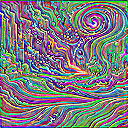

In [24]:
Image.fromarray(np.uint8(((XT[0].permute(1,2,0).cpu().clip(-1, 1) * 0.5 + 0.5) * 255).int().numpy()))

In [25]:
XT

tensor([[[[-0.1601, -0.4449, -0.1527,  ..., -0.7273, -0.6651, -0.1605],
          [ 0.2234, -0.2920,  1.4494,  ..., -1.4725, -3.1977, -0.4031],
          [-0.7709,  0.8744, -0.4156,  ..., -0.3608, -0.5966, -0.7490],
          ...,
          [-1.0764, -0.2004,  0.3185,  ...,  2.4978,  1.3888, -0.4232],
          [-1.0690, -1.0866, -0.0348,  ...,  0.3508,  0.4075, -0.2453],
          [ 0.1026, -1.2451, -1.1436,  ..., -0.6478, -0.4028, -0.3095]],

         [[ 0.4048, -0.4144,  0.1374,  ..., -1.0022, -0.6765, -0.3294],
          [-0.7432, -4.0654, -2.3538,  ...,  1.7831,  3.6494, -0.0059],
          [-0.3745, -0.6672,  0.1513,  ...,  0.9824,  1.4144,  0.5427],
          ...,
          [-0.2924, -1.1647,  0.2305,  ..., -0.0868, -1.1551, -0.8525],
          [-0.3277, -3.6470, -0.6719,  ..., -1.7194, -2.5075, -0.8732],
          [ 0.1375, -0.7055, -0.5689,  ...,  0.2136, -0.4145,  0.0772]],

         [[-0.2834, -0.9034, -0.8745,  ..., -0.4786, -0.8422, -0.2574],
          [-0.1186, -4.3686, -

In [29]:
def reconstruct_image_from_noise(XT, scheduler, image_pipe):
    X_t = XT.unsqueeze(0)

    for i, t in enumerate(scheduler.timesteps):
        model_input = scheduler.scale_model_input(X_t, t)
        with torch.no_grad():
            pred_epsilon = image_pipe.unet(model_input, t)["sample"]

        alpha_bar_t = scheduler.alphas_cumprod[t]
        if t != 0:
            alpha_bar_t_minus_delta_t = scheduler.alphas_cumprod[scheduler.timesteps[i + 1]]
        else:
            alpha_bar_t_minus_delta_t = torch.tensor(1.0)

        pred_X0 = (X_t - pred_epsilon * (1 - alpha_bar_t).sqrt()) / alpha_bar_t.sqrt()
        pred_X0.clamp(-1, 1)

        X_t_minus_delta_t = alpha_bar_t_minus_delta_t.sqrt() * pred_X0 + (1 - alpha_bar_t_minus_delta_t).sqrt() * pred_epsilon
        X_t = X_t_minus_delta_t

    return X_t

In [30]:
X_t = reconstruct_image_from_noise(XT[0], scheduler, image_pipe)

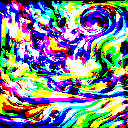

In [31]:
X_zero = X_t[0].squeeze(0).permute(1,2,0).clamp(-1, 1)
Image.fromarray(np.uint8(((X_zero.cpu().clip(-1, 1) * 0.5 + 0.5) * 255).long().numpy()))